In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

C:\Users\David\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# THIS CELL IS FOR TESTING THINGS, PLEASE IGNORE

#tst = session.query(Measurement).order_by(Measurement.date.desc()).first()
#print(tst.date)
#print(type(tst.date))
#dates
#tstd = pd.DataFrame(dates)
#tstd = tstd.groupby(['date'])
#tstd['prcp'].mean()
#type(precipDF)

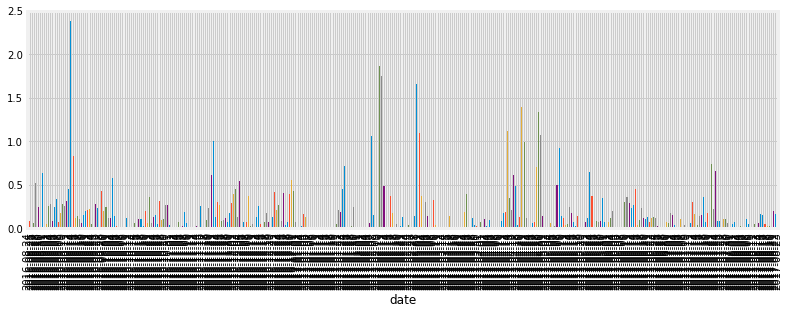

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last = session.query(Measurement).order_by(Measurement.date.desc()).first()
lastDT = last.date
lastDT = dt.datetime.strptime(lastDT, '%Y-%m-%d')
yearAgo = lastDT - dt.timedelta(days = 365)
# Perform a query to retrieve the data and precipitation scores
dates = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(yearAgo, lastDT)).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipDF = pd.DataFrame(dates)
precipDF = precipDF.dropna()
precipDF = precipDF.groupby(['date'])
precipDF = precipDF['prcp'].mean()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
precipDF.plot(kind = 'bar', figsize = (12,4))

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipTotal = pd.DataFrame(dates)
precipTotal['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationsAgg = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
stationsAgg

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# most active 'USC00519281'
temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')
highest = temps.order_by(Measurement.tobs.desc()).first()
lowest = temps.order_by(Measurement.tobs).first()
avgt = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
highest = highest[0]
lowest = lowest[0]
avgt = avgt[0]
tdata = [lowest, highest, avgt]
print(tdata)

[54.0, 85.0, 71.66378066378067]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237796435F8>]],
      dtype=object)

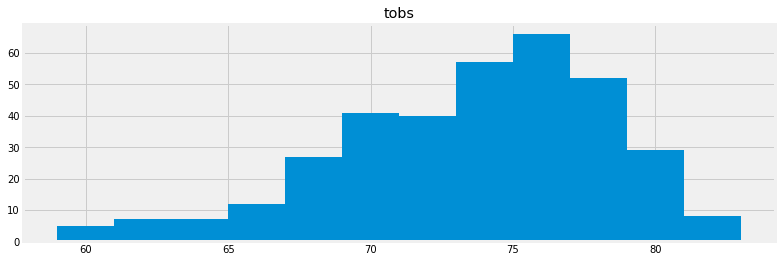

In [51]:
# Choose the station with the highest number of temperature observations.
stationsT = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
mostT = stationsT[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearlyT = session.query(Measurement.tobs).filter(Measurement.station == mostT).filter(Measurement.date.between(yearAgo, lastDT)).order_by(Measurement.tobs).all()
tDF = pd.DataFrame(yearlyT)
tDF.hist(figsize = (12,4), bins=12)


![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# NOTE: I didn't know escape characters could be used like that
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# 'same dates' meaning 02/28, 03/05 ?
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


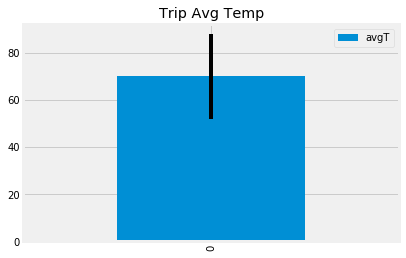

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tripT = calc_temps('2016-02-28', '2016-03-05')
tripDF = pd.DataFrame(tripT, columns = ['minT', 'avgT', 'maxT'])
#tripDF.head()
tripDF.plot(y = ['avgT'], yerr = tripDF['maxT'] - tripDF['minT'], title = 'Trip Avg Temp', kind = 'bar')

In [50]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
qstations = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                          filter(Measurement.station == Station.station).filter(Measurement.date.between('2016-02-28', '2016-03-05')).\
                          group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(qstations)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.33), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12000000000000001), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.02), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.01), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

#def daily_normals(date):
#    """Daily Normals.
    
#    Args:
#        date (str): A date string in the format '%m-%d'
        
#    Returns:
#        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
#    """
    
#    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
#    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
#daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


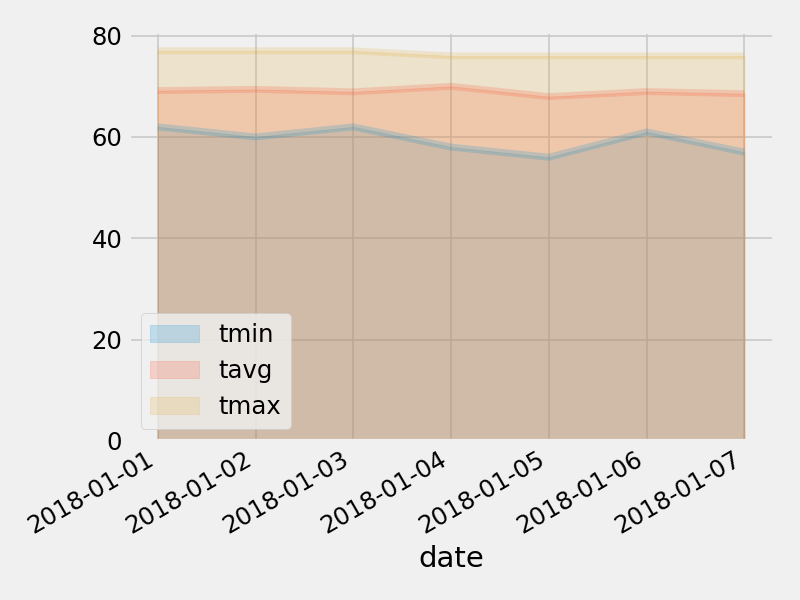

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
